# Novel Inertia Based Human Pose Estimation Using CNN

In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
from utils import *

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [ ]:
#Import data from MatLab SimScape Multibody Simulator

#data comes from two files
#1) n trajectories in xyz space, each length m
# traj = np.loadtxt(open("C:/Users/Derm/Desktop/traj_with_angs_1M.txt", "rb"), delimiter=",")
traj = np.loadtxt(open("simulation/data/traj_9DOF_100k.txt", "rb"), delimiter=",")

trajPts = np.shape(traj)[0] #points per trajectory
# numTraj = np.shape(traj)[1]//3 #number of total trajectories
numTraj = np.shape(traj)[1]//6 #number of total trajectories


#traj needs to be reshaped to a 3d numpy array
#as is traj[n] shows [x,y,z,x,y,z...]


#2) 7 joint angles at the end of the sequence
# jointPos = np.loadtxt(open("C:/Users/Derm/Desktop/jointPos_with_angs_1M.txt", "rb"), delimiter=",")
jointPos = np.loadtxt(open("simulation/data/jointPos_9DOF_100k.txt", "rb"), delimiter=",")

# print(traj[-1])
# print(jointPos[0])



In [3]:
#find and fix errors in data (small number of trials had huge joint angles)
err = np.argwhere(np.abs(jointPos) > 360)
print(err)

for i in err[:,0]:
    print(jointPos[i])
    jointPos[i] = jointPos[int(np.floor(np.random.rand()*np.shape(jointPos)[0]))]

# print(jointPos[17336])

[]


In [ ]:
#reshape traj data into 3d numpy array
# t = np.zeros([trajPts,3,numTraj]) #net 1
# for j in range(np.shape(traj)[0]):
#     for i in range(np.shape(traj)[1]//3):
#         t[j,:,i] = traj[j,3*i:3*(i+1)]
        
t = np.zeros([trajPts,6,numTraj]) #net 3
for j in range(np.shape(traj)[0]):
    for i in range(np.shape(traj)[1]//6):
        t[j,:,i] = traj[j,6*i:6*(i+1)]

        
# print(t[:,:,0]) #same as in MatLab
print(np.shape(t))
#swap axis so batch size is first axis (for TF)
t = np.swapaxes(t,0,2)
print(np.shape(t)) #[numTraj, xyz, trajPts]
#swap axis again so that conv1D moves on time and not xyz
t = np.swapaxes(t,1,2)
print(np.shape(t))

In [2]:
#Augment data to rotate about y axis

from utils import *

f1 = "simulation/data/traj_9DOF_100k.txt"
f2 = "simulation/data/jointPos_9DOF_100k.txt"
# f3 = "simulation/data/jointPath.txt"

t, jointPos = add_body_rotation(f1, f2, 100000)

saved augmented data as tbr, jbr


In [4]:
# from network import Net1 #optim for 1M linear dataset (not ideal because used inconsistant timesteps in solver)
# from network import Net2 #optim for 100k time varying
# from network import Net3 #optim for data with position and rotation
from network import Net4 #for 9DOF model

np.random.seed(1337)

#convert data from numpy to tensors
x_train = tf.convert_to_tensor(t,np.float32)
y_train = tf.convert_to_tensor(jointPos,np.float32)

# print(tf.shape(x_train))
# print(x_train[0,:,1])

In [13]:
# model = Net1()
# model = Net3()
model = Net4()

runLen = 300    

def scheduler(epoch, lr):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.001
        return lr
    if epoch >= part2:
        lr = 0.0001
        return lr

#model1
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],)


summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#for 1M linear dataset
# trace = model.fit(x=x_train, y=y_train, batch_size=128, epochs=runLen, verbose=1, 
#                   validation_split=0.1, callbacks = [callback], shuffle=True) 
#New Changes- added 512 conv layer to network #Increases performance drastically (reaches val error of 89.0 in <30 epoch) 
#             adding another layer of 1024 (reaches val error of ~81.5 in <30 epoch)

# for 1M dataset with endpoint angles
# trace = model.fit(x=x_train, y=y_train, batch_size=128, epochs=runLen, verbose=1, 
#                   validation_split=0.1, callbacks = [callback], shuffle=True)
#new changes: added 512 layers back in


# for 10k 10DOF dataset with endpoint angles and body rotation
trace = model.fit(x=x_train, y=y_train, batch_size=32, epochs=runLen, verbose=1, 
                  validation_split=0.1, callbacks = [callback], shuffle=True)
#new changes: added 512 layers back in

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 10, 6)        24          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 8, 16)        304         batch_normalization_16[0][0]     
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 8, 16)        784         conv1d_13[0][0]                  
_______________________________________________________________________________________

2813/2813 [==============================] - 30s 11ms/step - loss: 855.3422 - mean_squared_error: 855.3422 - val_loss: 644.4478 - val_mean_squared_error: 644.4478
Epoch 2/300
2813/2813 [==============================] - 29s 10ms/step - loss: 625.3652 - mean_squared_error: 625.3652 - val_loss: 643.4209 - val_mean_squared_error: 643.4209
Epoch 3/300
2813/2813 [==============================] - 29s 10ms/step - loss: 558.3350 - mean_squared_error: 558.3350 - val_loss: 574.5314 - val_mean_squared_error: 574.5314
Epoch 4/300
2813/2813 [==============================] - 30s 11ms/step - loss: 506.1145 - mean_squared_error: 506.1145 - val_loss: 478.4909 - val_mean_squared_error: 478.4909
Epoch 5/300
2813/2813 [==============================] - 30s 11ms/step - loss: 468.5485 - mean_squared_error: 468.5485 - val_loss: 444.1839 - val_mean_squared_error: 444.1839
Epoch 6/300
2813/2813 [==============================] - 30s 11ms/step - loss: 431.6296 - mean_squared_error: 431.6296 - val_loss: 525.74

Epoch 48/300
2813/2813 [==============================] - 30s 10ms/step - loss: 226.7073 - mean_squared_error: 226.7073 - val_loss: 245.5610 - val_mean_squared_error: 245.5610
Epoch 49/300
2813/2813 [==============================] - 30s 11ms/step - loss: 222.9852 - mean_squared_error: 222.9852 - val_loss: 269.0573 - val_mean_squared_error: 269.0573
Epoch 50/300
2813/2813 [==============================] - 29s 10ms/step - loss: 225.4977 - mean_squared_error: 225.4977 - val_loss: 228.2834 - val_mean_squared_error: 228.2834
Epoch 51/300
2813/2813 [==============================] - 29s 10ms/step - loss: 222.3956 - mean_squared_error: 222.3956 - val_loss: 234.0902 - val_mean_squared_error: 234.0902
Epoch 52/300
2813/2813 [==============================] - 29s 10ms/step - loss: 224.0972 - mean_squared_error: 224.0972 - val_loss: 268.6836 - val_mean_squared_error: 268.6836
Epoch 53/300
2813/2813 [==============================] - 30s 10ms/step - loss: 224.3308 - mean_squared_error: 224.3308 

2813/2813 [==============================] - 29s 10ms/step - loss: 191.7645 - mean_squared_error: 191.7645 - val_loss: 298.2396 - val_mean_squared_error: 298.2396
Epoch 95/300
2813/2813 [==============================] - 29s 10ms/step - loss: 193.4308 - mean_squared_error: 193.4308 - val_loss: 252.9603 - val_mean_squared_error: 252.9603
Epoch 96/300
2813/2813 [==============================] - 29s 10ms/step - loss: 188.3956 - mean_squared_error: 188.3956 - val_loss: 221.1007 - val_mean_squared_error: 221.1007
Epoch 97/300
2813/2813 [==============================] - 30s 11ms/step - loss: 188.9310 - mean_squared_error: 188.9310 - val_loss: 260.3078 - val_mean_squared_error: 260.3078
Epoch 98/300
2813/2813 [==============================] - 30s 11ms/step - loss: 191.6279 - mean_squared_error: 191.6279 - val_loss: 209.9623 - val_mean_squared_error: 209.9623
Epoch 99/300
2813/2813 [==============================] - 29s 10ms/step - loss: 188.2811 - mean_squared_error: 188.2811 - val_loss: 3

2813/2813 [==============================] - 30s 11ms/step - loss: 156.1770 - mean_squared_error: 156.1770 - val_loss: 184.8466 - val_mean_squared_error: 184.8466
Epoch 141/300
2813/2813 [==============================] - 30s 10ms/step - loss: 156.1767 - mean_squared_error: 156.1767 - val_loss: 177.3638 - val_mean_squared_error: 177.3638
Epoch 142/300
2813/2813 [==============================] - 30s 11ms/step - loss: 155.5188 - mean_squared_error: 155.5188 - val_loss: 190.1241 - val_mean_squared_error: 190.1241
Epoch 143/300
2813/2813 [==============================] - 29s 10ms/step - loss: 155.4279 - mean_squared_error: 155.4279 - val_loss: 174.6528 - val_mean_squared_error: 174.6528
Epoch 144/300
2813/2813 [==============================] - 30s 11ms/step - loss: 155.2031 - mean_squared_error: 155.2031 - val_loss: 176.4489 - val_mean_squared_error: 176.4489
Epoch 145/300
2813/2813 [==============================] - 30s 11ms/step - loss: 155.6131 - mean_squared_error: 155.6131 - val_lo

2813/2813 [==============================] - 29s 10ms/step - loss: 151.6339 - mean_squared_error: 151.6339 - val_loss: 173.4577 - val_mean_squared_error: 173.4577
Epoch 187/300
2813/2813 [==============================] - 29s 10ms/step - loss: 151.6340 - mean_squared_error: 151.6340 - val_loss: 173.0774 - val_mean_squared_error: 173.0774
Epoch 188/300
2813/2813 [==============================] - 29s 10ms/step - loss: 151.5910 - mean_squared_error: 151.5910 - val_loss: 176.1439 - val_mean_squared_error: 176.1439
Epoch 189/300
2813/2813 [==============================] - 29s 10ms/step - loss: 151.9379 - mean_squared_error: 151.9379 - val_loss: 176.7103 - val_mean_squared_error: 176.7103
Epoch 190/300
2813/2813 [==============================] - 29s 10ms/step - loss: 151.4568 - mean_squared_error: 151.4568 - val_loss: 172.5417 - val_mean_squared_error: 172.5417
Epoch 191/300
2813/2813 [==============================] - 30s 11ms/step - loss: 151.7792 - mean_squared_error: 151.7792 - val_lo

2813/2813 [==============================] - 29s 10ms/step - loss: 147.4328 - mean_squared_error: 147.4328 - val_loss: 170.4509 - val_mean_squared_error: 170.4509
Epoch 233/300
2813/2813 [==============================] - 30s 10ms/step - loss: 147.4135 - mean_squared_error: 147.4135 - val_loss: 170.6337 - val_mean_squared_error: 170.6337
Epoch 234/300
2813/2813 [==============================] - 30s 11ms/step - loss: 148.0282 - mean_squared_error: 148.0282 - val_loss: 170.7110 - val_mean_squared_error: 170.7110
Epoch 235/300
2813/2813 [==============================] - 30s 11ms/step - loss: 148.1268 - mean_squared_error: 148.1268 - val_loss: 170.9620 - val_mean_squared_error: 170.9620
Epoch 236/300
2813/2813 [==============================] - 30s 11ms/step - loss: 147.9755 - mean_squared_error: 147.9755 - val_loss: 170.5228 - val_mean_squared_error: 170.5228
Epoch 237/300
2813/2813 [==============================] - 29s 10ms/step - loss: 147.6387 - mean_squared_error: 147.6387 - val_lo

2813/2813 [==============================] - 30s 11ms/step - loss: 147.3375 - mean_squared_error: 147.3375 - val_loss: 170.7099 - val_mean_squared_error: 170.7099
Epoch 279/300
2813/2813 [==============================] - 30s 11ms/step - loss: 147.4771 - mean_squared_error: 147.4771 - val_loss: 170.7867 - val_mean_squared_error: 170.7867
Epoch 280/300
2813/2813 [==============================] - 29s 10ms/step - loss: 147.5513 - mean_squared_error: 147.5513 - val_loss: 170.5032 - val_mean_squared_error: 170.5032
Epoch 281/300
2813/2813 [==============================] - 29s 10ms/step - loss: 147.2250 - mean_squared_error: 147.2250 - val_loss: 170.5120 - val_mean_squared_error: 170.5120
Epoch 282/300
2813/2813 [==============================] - 29s 10ms/step - loss: 147.8489 - mean_squared_error: 147.8489 - val_loss: 170.5313 - val_mean_squared_error: 170.5313
Epoch 283/300
2813/2813 [==============================] - 29s 10ms/step - loss: 147.0668 - mean_squared_error: 147.0668 - val_lo

Text(0, 0.5, 'loss')

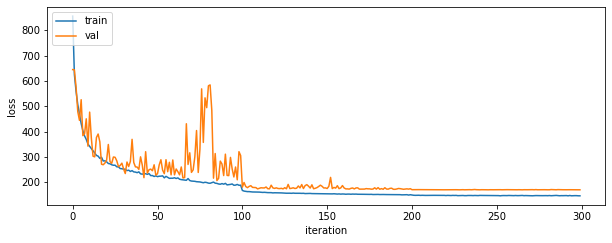

In [15]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')
# plt.ylim(10,1000)

In [18]:
#test model- IMPORTANT TO USE NEVER BEFORE SEEN DATA

ft1 = "simulation/data/traj_9DOF_1.txt"
ft2 = "simulation/data/jointPos_9DOF_1.txt"

tTest, jointPosTest = add_body_rotation(ft1, ft2, 1)
# print("tTest" , tTest)
# print("jointPosTest", jointPosTest)
# print(" ")

x_test = tf.convert_to_tensor(tTest,np.float32)
y_test = tf.convert_to_tensor(jointPosTest,np.float32)

prediction = model.predict(x_test)
error = (y_test - prediction)

#average error for estimates for each joint
avg = np.average(abs(error),axis=0)
print("average error = ", avg)

#range for each joint:
ranges = [50, 60, 67.5, 110, 120, 360, 130, 180, 110, 360]
rel_error = avg/ranges
print("error as frac of joint range = ", np.floor(rel_error*1000)/1000) #1 is full range of joint
print("total error = ",sum(rel_error))

#current best for network 1 is: 
#                 0.438 @ [0.09  0.082 0.034 0.086 0.061 0.024 0.058]
#                 val_error: 81.84

#current best for network 3 is: 
#                 0.289 @ [0.068 0.076 0.031 0.046 0.025 0.012 0.029]
#                 val_error: 26.61 
#                 (using 100k dataset)

print("prediction: ",prediction[0])
print("actual: ", y_test[0])

np.save("simulation/data/prediction.npy", prediction)

saved augmented data as tbr, jbr
average error =  [ 2.4938793  8.842675   3.998671  29.92567   36.234848   3.0027924
  9.204422  35.996773  12.151637  10.635384 ]
error as frac of joint range =  [0.049 0.147 0.059 0.272 0.301 0.008 0.07  0.199 0.11  0.029]
total error =  1.249642262830539
prediction:  [ 8.3537948e-01 -1.6462524e-01  2.8228760e-02 -2.2783970e+01
 -7.2938499e+00  3.7840794e+01 -1.1202558e+02  2.8530228e+01
 -6.1236292e-01  7.5059967e+01]
actual:  tf.Tensor(
[  -1.6585    -9.0073     4.0269     7.1417    28.941     34.838
 -121.23      64.527    -12.764     85.69535], shape=(10,), dtype=float32)


In [19]:
# model.save("trajectory_cls.kmod")

# model.save("trajectory_random_forces_cls.kmod")

# model.save("trajectory_with_angs.kmod")

# model.save("9DOF_with_angs.kmod")

model.save("10DOF.kmod")

INFO:tensorflow:Assets written to: 10DOF.kmod\assets


In [ ]:
#load best scoring model

model = tf.keras.models.load_model("10DOF.kmod")

In [ ]:
#proof my model is doing better than completely random guessing

np.random.seed(None)

# print(actual)
# print(tf.shape(actual)) #[99 7]
B = tf.random.uniform([1000,7])

# B = tf.ones([99,7])
B = B *tf.constant([25., 30., 33.75, 55. , 60., 180., 65.]) + tf.constant([0., 0., 26.25, -35., 30., 0., -65.])

# print(tf.shape(B))
# print(tf.shape(actual))

fake_error = (y_test - B)
# print(fake_error)

fake_avg = tf.math.reduce_mean(tf.math.abs(fake_error), axis=0)
print(fake_avg)

rel_fake_error = fake_avg/ranges

print("error as frac of joint range: ",rel_fake_error)
print("total error: ", sum(rel_fake_error))

#NOTE: these are not all the same becuase the starting ranges for joint positions do NOT fall in the middle of all
#      possible positions for each joint

In [ ]:
from scipy.spatial.transform import Rotation as R
r = R.from_euler('zyx', [
[90, 0, 0],
[0, 45, 0],
[45, 60, 30]], degrees=True)

print(r)
r.as_quat()

v = [1, 2, 3]

r.apply(v)

In [ ]:
r1 = R.from_euler('z', 90, degrees=True)
r2 = R.from_euler('x', 90, degrees=True)
r3 = r1*r2

v = [1, 2, 3]

rot1 = r1.apply(v)
rot2 = r3.apply(v)
print(rot2)


In [ ]:
a, b, c= r3.apply([1, 2, 3])
print(a,b,c)
